# STA365
## Homework 6

---

### Question 1

Consider a [location-scale-t](https://en.wikipedia.org/wiki/Student%27s_t-distribution#Location-scale_t-distribution)-norm-halfnorm-discrete-uniform
Um yeah we're gonna need a Metropolis cleanup on aisles one two and three  
(or a slice or adapative squeeze rejection sampling steps... in place of Metropolis steps)

*Implement the a Metropslis within Gibbs algorithm to sample from the posterior of the above specification. Use a "smallish" sample size, say $n=100$ and implement your acceptance probability on a log-scale as described in [piazza post @65_f1](https://piazza.com/class/m5jvyco84083fm/post/65_f1)*

Answer: 

Given a "[location-scale-t](https://en.wikipedia.org/wiki/Student%27s_t-distribution#Location-scale_t-distribution)-norm-halfnorm-discrete-uniform" specification,

$$\large
\overset{x_i\; \sim\; \text{location-scale-t}(\mu, \sigma^2, \nu)}{\quad\quad\quad p(x|\mu,\sigma^2, \nu)} = {\prod_{i=1}^n
\frac{\Gamma\left(\frac{\nu+1}{2}\right)}{\Gamma\left(\frac{\nu}{2}\right) \sqrt{\pi \nu \sigma^2}}\left(1+\frac{1}{\nu} \frac{(x_i-\mu)^2}{\sigma^2}\right)^{-(\nu+1) / 2}}$$

$$\scriptsize 
\begin{align}
p(\mu | \mu_0, \tau_0) &={} \sqrt{\frac{\tau_0}{2\pi}} e^{-\frac{\tau_0}{2}\left(\mu-\mu_0\right)^2} & p(\sigma^2 | \sigma_0^2) &={} \sqrt{\frac{2}{\pi\sigma_0^2}} \exp \left(-\frac{(\sigma^2)^2}{2 \sigma_0^2}\right) 1_{[0,\infty]}(\sigma^2) & p(\nu=i) &={} \Bigg\{ \begin{array}{cl} \frac{1}{100} & \text{for }i=1,\cdots,100\\ 0 & \text{otherwise} \end{array}\\
& \textrm{normal} && \textrm{half-normal} && \textrm{discrete uniform}
\end{align}
$$


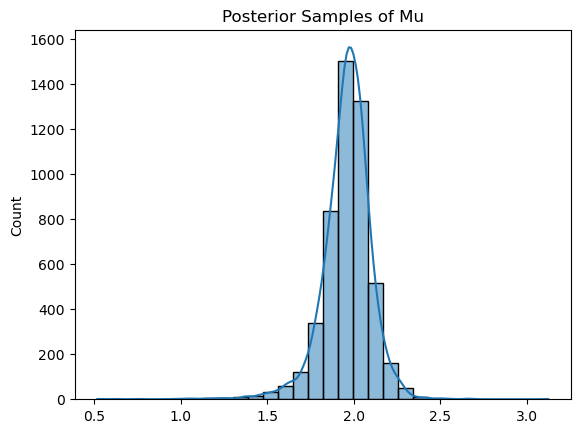

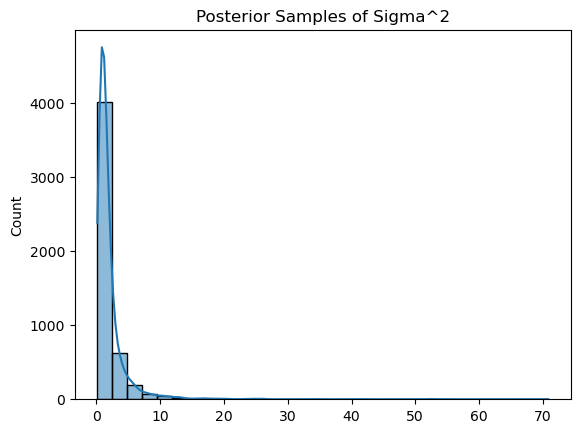

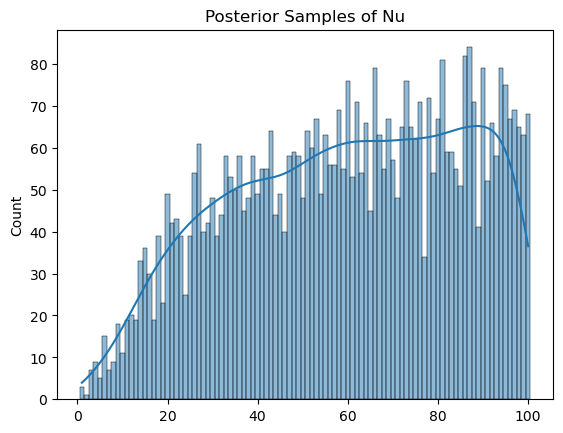

In [10]:
import numpy as np
import scipy.stats as stats

def metropolis_within_gibbs(n_iter=5000, n=100, mu_0=0, tau_0=1, sigma_0=1, nu_max=100):
    # Initialize parameters
    mu = np.random.normal(mu_0, tau_0)
    sigma2 = np.abs(np.random.normal(0, sigma_0))
    nu = np.random.randint(1, nu_max + 1)
    
    # Generate synthetic data from location-scale-t distribution
    x = stats.t.rvs(df=nu, loc=mu, scale=np.sqrt(sigma2), size=n)
    
    # Storage for posterior samples
    mu_samples = np.zeros(n_iter)
    sigma2_samples = np.zeros(n_iter)
    nu_samples = np.zeros(n_iter)
    
    for i in range(n_iter):
        # 1. Sample mu | rest (Normal)
        tau_n = tau_0 + n / sigma2
        mu_n = (tau_0 * mu_0 + np.sum(x) / sigma2) / tau_n
        mu = np.random.normal(mu_n, np.sqrt(1 / tau_n))
        
        # 2. Sample sigma2 | rest (Half-Normal)
        shape = 2 / (sigma_0 ** 2)
        scale = 1 / (2 * sigma_0 ** 2)
        sigma2 = 1 / np.random.gamma(shape, scale)
        
        # 3. Sample nu | rest (Metropolis-Hastings with discrete uniform prior)
        nu_proposed = np.random.randint(1, nu_max + 1)
        
        # Compute log acceptance probability
        log_p_current = np.sum(stats.t.logpdf(x, df=nu, loc=mu, scale=np.sqrt(sigma2)))
        log_p_proposed = np.sum(stats.t.logpdf(x, df=nu_proposed, loc=mu, scale=np.sqrt(sigma2)))
        
        log_accept_ratio = log_p_proposed - log_p_current
        
        if np.log(np.random.uniform()) < log_accept_ratio:
            nu = nu_proposed
        
        # Store samples
        mu_samples[i] = mu
        sigma2_samples[i] = sigma2
        nu_samples[i] = nu
    
    return mu_samples, sigma2_samples, nu_samples

# Run the sampler
mu_samples, sigma2_samples, nu_samples = metropolis_within_gibbs()

# Display summary statistics
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(mu_samples, kde=True, bins=30)
plt.title("Posterior Samples of Mu")
plt.show()

sns.histplot(sigma2_samples, kde=True, bins=30)
plt.title("Posterior Samples of Sigma^2")
plt.show()

sns.histplot(nu_samples, kde=True, bins=30, discrete=True)
plt.title("Posterior Samples of Nu")
plt.show()


---
### Question 2

*Implement the specification above using `PyMC` where you can explore inference on $\nu$ at different sample sizes. Provide a summarization and explanation of your findings.*

Answer:

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [mu, sigma]
>Metropolis: [nu]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 3 seconds.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [mu, sigma]
>Metropolis: [nu]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 3 seconds.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [mu, sigma]
>Metropolis: [nu]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 3 seconds.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [mu, sigma]
>Metropolis: [nu]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 4 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


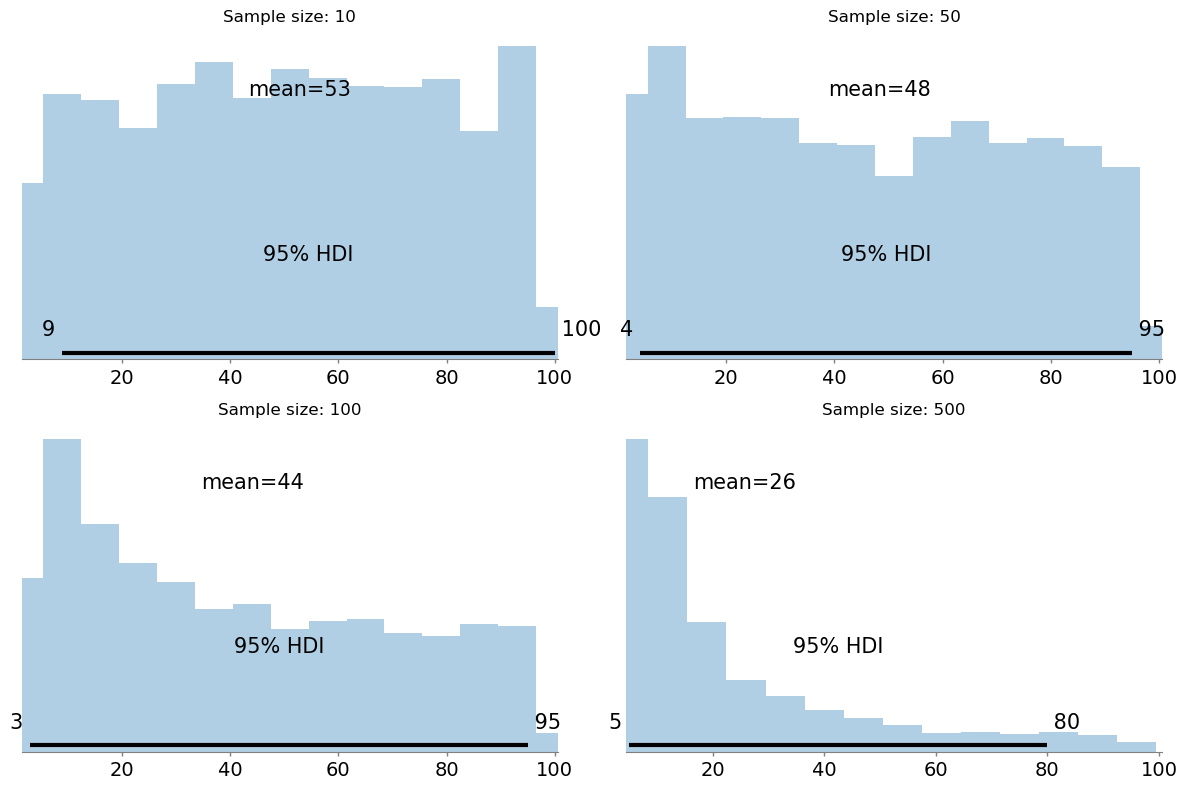

In [14]:
import pymc as pm
import numpy as np
import arviz as az
import matplotlib.pyplot as plt

# Function to run Bayesian inference with PyMC
def run_pymc_inference(n, nu_true=10, draws=2000, tune=1000):
    # Generate synthetic data from t-distribution
    mu_true = 0
    sigma_true = 1
    x = np.random.standard_t(df=nu_true, size=n) * sigma_true + mu_true
    
    with pm.Model() as model:
        # Priors
        mu = pm.Normal("mu", mu=0, sigma=5)
        sigma = pm.HalfNormal("sigma", sigma=2)
        nu = pm.DiscreteUniform("nu", lower=1, upper=100)
        
        # Likelihood
        likelihood = pm.StudentT("obs", nu=nu, mu=mu, sigma=sigma, observed=x)
        
        # Sampling
        trace = pm.sample(draws=draws, tune=tune, target_accept=0.9, return_inferencedata=True)
    
    return trace

# Sample sizes to test
sample_sizes = [10, 50, 100, 500]
traces = {n: run_pymc_inference(n) for n in sample_sizes}

# Plot posterior distributions for nu
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()
for i, n in enumerate(sample_sizes):
    az.plot_posterior(traces[n]["posterior"].nu, ax=axes[i], hdi_prob=0.95)
    axes[i].set_title(f"Sample size: {n}")
plt.tight_layout()
plt.show()

**Interpretation**

The plots indicate that the low sample sizes has high uncertainty for $\nu$, making it hard to distinguish between a t-distribution and a Normal distribution. On the other hand, the large sample sizes at $n=100$ and $n=500$, the model narrows its estimate of $\nu$ by strngly suggesting a lower value for $\nu$ and favoring Student-T with heavier tails. Thus, showing that Bayesian has improved the inference on $\nu$ by refninig our belief about the degrees of freedom.

---
### Q3: the posterior predictive distribution does something like the following...

Let $p(\tau_i)$ be $\require{cancel} \textrm{gamma}\big(\tau_i | \alpha = \frac{\nu}{2}, \overset{\textrm{rate}\xcancel{\textrm{scale}}}{\beta = \frac{\nu}{2}}\big)$ and let $p(y_i|\tau_i)$ be $\textrm{N}(y_i | 0,\tau_i)$ and now integrate out the uncertainty in $\tau_i$ and see what distribution is left over for $y_i$.

*Go look at the gamma distribution and remember that you know that the integrals of unnormalized densities are the inverse of their normalizing constants. Then go look at the t distribution and determine what distribution the following expression defines. Then explain why the behavior demonstrated here is analagous to that of the posterior predictive distribution.*

Answer:

$$p(\tau_i) \text{~ Gamma}(\alpha = \frac{\nu}{2}, \beta = \frac{\nu}{2})\\
p(y_i | \tau_i) \text{~} \mathcal{N}(0, 1/\tau_i)$$

We want to find the marginal distribution of $y_i$ after integrating out the $\tau_i$


$$
\begin{align}
p(y_i) &= \int p(y_i | \tau_i) p(\tau_i) d\tau_i \\
&= \int \sqrt{\frac{\tau_i}{2\pi}} e^{-\frac{1}{2} \tau_i y_i^2} \cdot \frac{(\nu/2)^{\nu/2}}{\Gamma(\nu/2)} \tau_i^{\nu/2 - 1} e^{-\nu \tau_i / 2} d\tau_i\\
&= \frac{(\nu/2)^{\nu/2}}{\sqrt{2\pi}\Gamma(\nu/2)} \int_0^\infty \tau_i^{(\nu/2 + 1/2) - 1} e^{-(\nu/2 + y_i^2/2) \tau_i} d\tau_i \\
&= \frac{(\nu/2)^{\nu/2}}{\sqrt{2\pi}\Gamma(\nu/2)} \cdot \frac{\Gamma(\nu+1/2)}{(\frac{\nu+y_i^2}{2})^{(\nu+1)/2}} \\
&= \frac{\Gamma(\frac{\nu+1}{2})}{\sqrt{\nu \pi} \Gamma(\nu/2)} \left( 1 + \frac{y_i^2}{\nu} \right)^{-\frac{\nu+1}{2}}
\end{align}$$

The integration above uses the fact that the standard Gamma integral identity is:
$$\begin{align}
    \int_0^\infty x^{a-1} e^{-bx} dx = \frac{\Gamma(a)}{b^a},
\end{align}$$
where we set:
$$\begin{align}
    a &= \frac{\nu+1}{2}, \quad b = \frac{\nu + y_i^2}{2}.
\end{align}$$


Thus, we see that the integration follows a Gamma-Normal conjugacy, so the result follows:
$$p(y_i) \sim t_{\nu}(0,1)$$

where $t_{\nu}(0,1)$ is the Student's t-distribution with:
1. Degrees of freedom: $\nu$
2. Mean: $0$
3. Scale: $1$

This derivation shows that the posterior predictive distribution accounts for uncertainty in variance by integrating over all possible precisions $\tau_i$. The key observations are:
1. If variance was fixed, $y_i$ would follow a normal distribution.
2. By incorporating variance uncertainty, the result is a heavier-tailed Student-t distribution, making Bayesian inference more robust to outliers.
3. This explains why posterior predictive distributions often exhibit wider tails, reflecting uncertainty in parameter estimation.

Hence, showing that marginalizing over variance uncertainty leads to a Student-t distribution, explaining its heavier tails and robustness to outliers. 

